## A demo using Hydrogen Hamiltonian with GPT-QE.

In [10]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from gqe.mingpt.utils import set_seed

set_seed(31)

In [11]:
from qwrapper.operator import PauliObservable
from gqe.mingpt.cost import EnergyCost
from qswift.compiler import DefaultOperatorPool
from benchmark.molecule import DiatomicMolecularHamiltonian
from gqe.operator_pool.uccsd import UCCSD, generate_molecule
from gqe.common.initializer import HFStateInitializer
from gqe.mingpt.callback import DefaultCallback, PrintMonitor, FileMonitor
from gqe.util import get_device

#molecule = generate_molecule("H", "H", 0.7414, "sto-3g")
molecule = generate_molecule("H", "H", 1.5, "sto-3g", bravyi_kitaev=False)
nqubit = 4

# prepare Hamiltonian
hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule, bravyi_kitaev=False)

# prepare operator_pool
uccsd = UCCSD(nqubit, molecule)
paulis = uccsd.paulis
paulis.append(PauliObservable("IIII"))
print('paulis', paulis)
num_operators = len(paulis)
initializer = HFStateInitializer(n_electrons=2)
pool = DefaultOperatorPool(paulis)
cost = EnergyCost(hamiltonian, initializer, pool,
                  [0.00625, -0.00625, 0.0125, -0.0125, 0.025, -0.025, 0.05,
                   -0.05, 0.1, -0.1], device=get_device())
print(hamiltonian.exact_value(initializer.init_circuit(4, [], "qulacs")))

converged SCF energy = -0.910873554594387
Starting to parse FermionOperator using 4 qubits...

Operator t:  -0.49178577730353756 [] +
-0.0573839840149255 [X0 X1 Y2 Y3] +
0.0573839840149255 [X0 Y1 Y2 X3] +
0.0573839840149255 [Y0 X1 X2 Y3] +
-0.0573839840149255 [Y0 Y1 X2 X3] +
0.09345649667701589 [Z0] +
0.13817584576560335 [Z0 Z1] +
0.08253705488832763 [Z0 Z2] +
0.13992103890325314 [Z0 Z3] +
0.09345649667701589 [Z1] +
0.13992103890325314 [Z1 Z2] +
0.08253705488832763 [Z1 Z3] +
-0.03564481621009516 [Z2] +
0.1458551903009311 [Z2 Z3] +
-0.035644816210095145 [Z3]
Term, coeff:  () -0.49178577730353756
Term, coeff:  ((0, 'Z'),) 0.09345649667701589
Index, p_char:  0 Z
Term, coeff:  ((1, 'Z'),) 0.09345649667701589
Index, p_char:  1 Z
Term, coeff:  ((2, 'Z'),) -0.03564481621009516
Index, p_char:  2 Z
Term, coeff:  ((3, 'Z'),) -0.035644816210095145
Index, p_char:  3 Z
Term, coeff:  ((0, 'Z'), (1, 'Z')) 0.13817584576560335
Index, p_char:  0 Z
Index, p_char:  1 Z
Term, coeff:  ((0, 'Y'), (1, 'X'), (

## FCI energy by diagonalization

In [12]:
from qwrapper.hamiltonian import compute_ground_state

print(compute_ground_state(hamiltonian))

-0.9981493534714105


## Setup for GPT

In [13]:
# create a GPT instance
from gqe.mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = cost.vocab_size()
model_config.block_size = cost.vocab_size()
model_config.n_gates = 10  # The number of gates for each circuit
model_config.temperature = 5  # Each gate is generated with probability exp(-temperature * logit)
model_config.embd_pdrop = 0
model_config.resid_pdrop = 0
model_config.attn_pdrop = 0
model = GPT(model_config, cost)

number of parameters: 85.29M


In [14]:
# create a Trainer object
from gqe.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-7  # the model we're using is so small that we can go a bit faster
train_config.max_iters = 100
train_config.num_workers = 0
train_config.n_samples = 10
trainer = Trainer(train_config, model)

running on device mps


In [15]:
file_monitor = FileMonitor()
callback_generator = DefaultCallback(model, monitors=[PrintMonitor(), file_monitor])

trainer.set_callback('on_batch_end', callback_generator.generate())
trainer.run()
torch.save(model.state_dict(), '../saved_models/gptqe_test_2')
file_monitor.save('../output/test_batch.json')

iter_dt 0.00s; iter 0: train loss 0.63129 temperature: 5
mean_logits tensor([-1.4047, -1.2267, -1.0876, -1.0766, -0.9446, -0.7685, -0.9687, -1.2123,
        -0.9128, -1.2861], device='mps:0', grad_fn=<MulBackward0>)
energies: tensor([-0.8600, -0.9027, -0.9449, -0.9333, -0.8843, -0.9100, -0.9131, -0.9089,
        -0.7806, -0.9316], device='mps:0')
mean: tensor(-0.8969, device='mps:0')
iter_dt 1695248771.31s; iter 1: train loss 0.09340 temperature: 5.05
mean_logits tensor([-1.0458, -1.0537, -1.1011, -1.0870, -0.8403, -0.9314, -0.9896, -1.0327,
        -0.9479, -0.9384], device='mps:0', grad_fn=<MulBackward0>)
energies: tensor([-0.9767, -0.8377, -0.9507, -0.9877, -0.9650, -0.9043, -0.9178, -0.8659,
        -0.9130, -0.9125], device='mps:0')
mean: tensor(-0.9231, device='mps:0')
iter_dt 0.96s; iter 2: train loss 0.11175 temperature: 5.1
mean_logits tensor([-1.0109, -1.1015, -0.9018, -0.9996, -0.9258, -0.8629, -0.9221, -0.7616,
        -1.0314, -0.8989], device='mps:0', grad_fn=<MulBackward

In [16]:
indices, logits = model.generate(torch.tensor([[0]]).to(get_device()), model_config.n_gates)
print(cost.energy(indices))

tensor([-0.9959], device='mps:0')


In [17]:
model.temperature = 20
model.load_state_dict(torch.load('../saved_models/gptqe_test_2'))
indices, logits = model.generate(torch.zeros(10, 1, dtype=torch.int).to(get_device()), model_config.n_gates)
cost.sequence.tool = "qiskit"
index = torch.argmin(cost.energy(indices)).item()

tensor([-0.9971], device='mps:0')
[147  17  17 103 147  61 130  10  51  54]


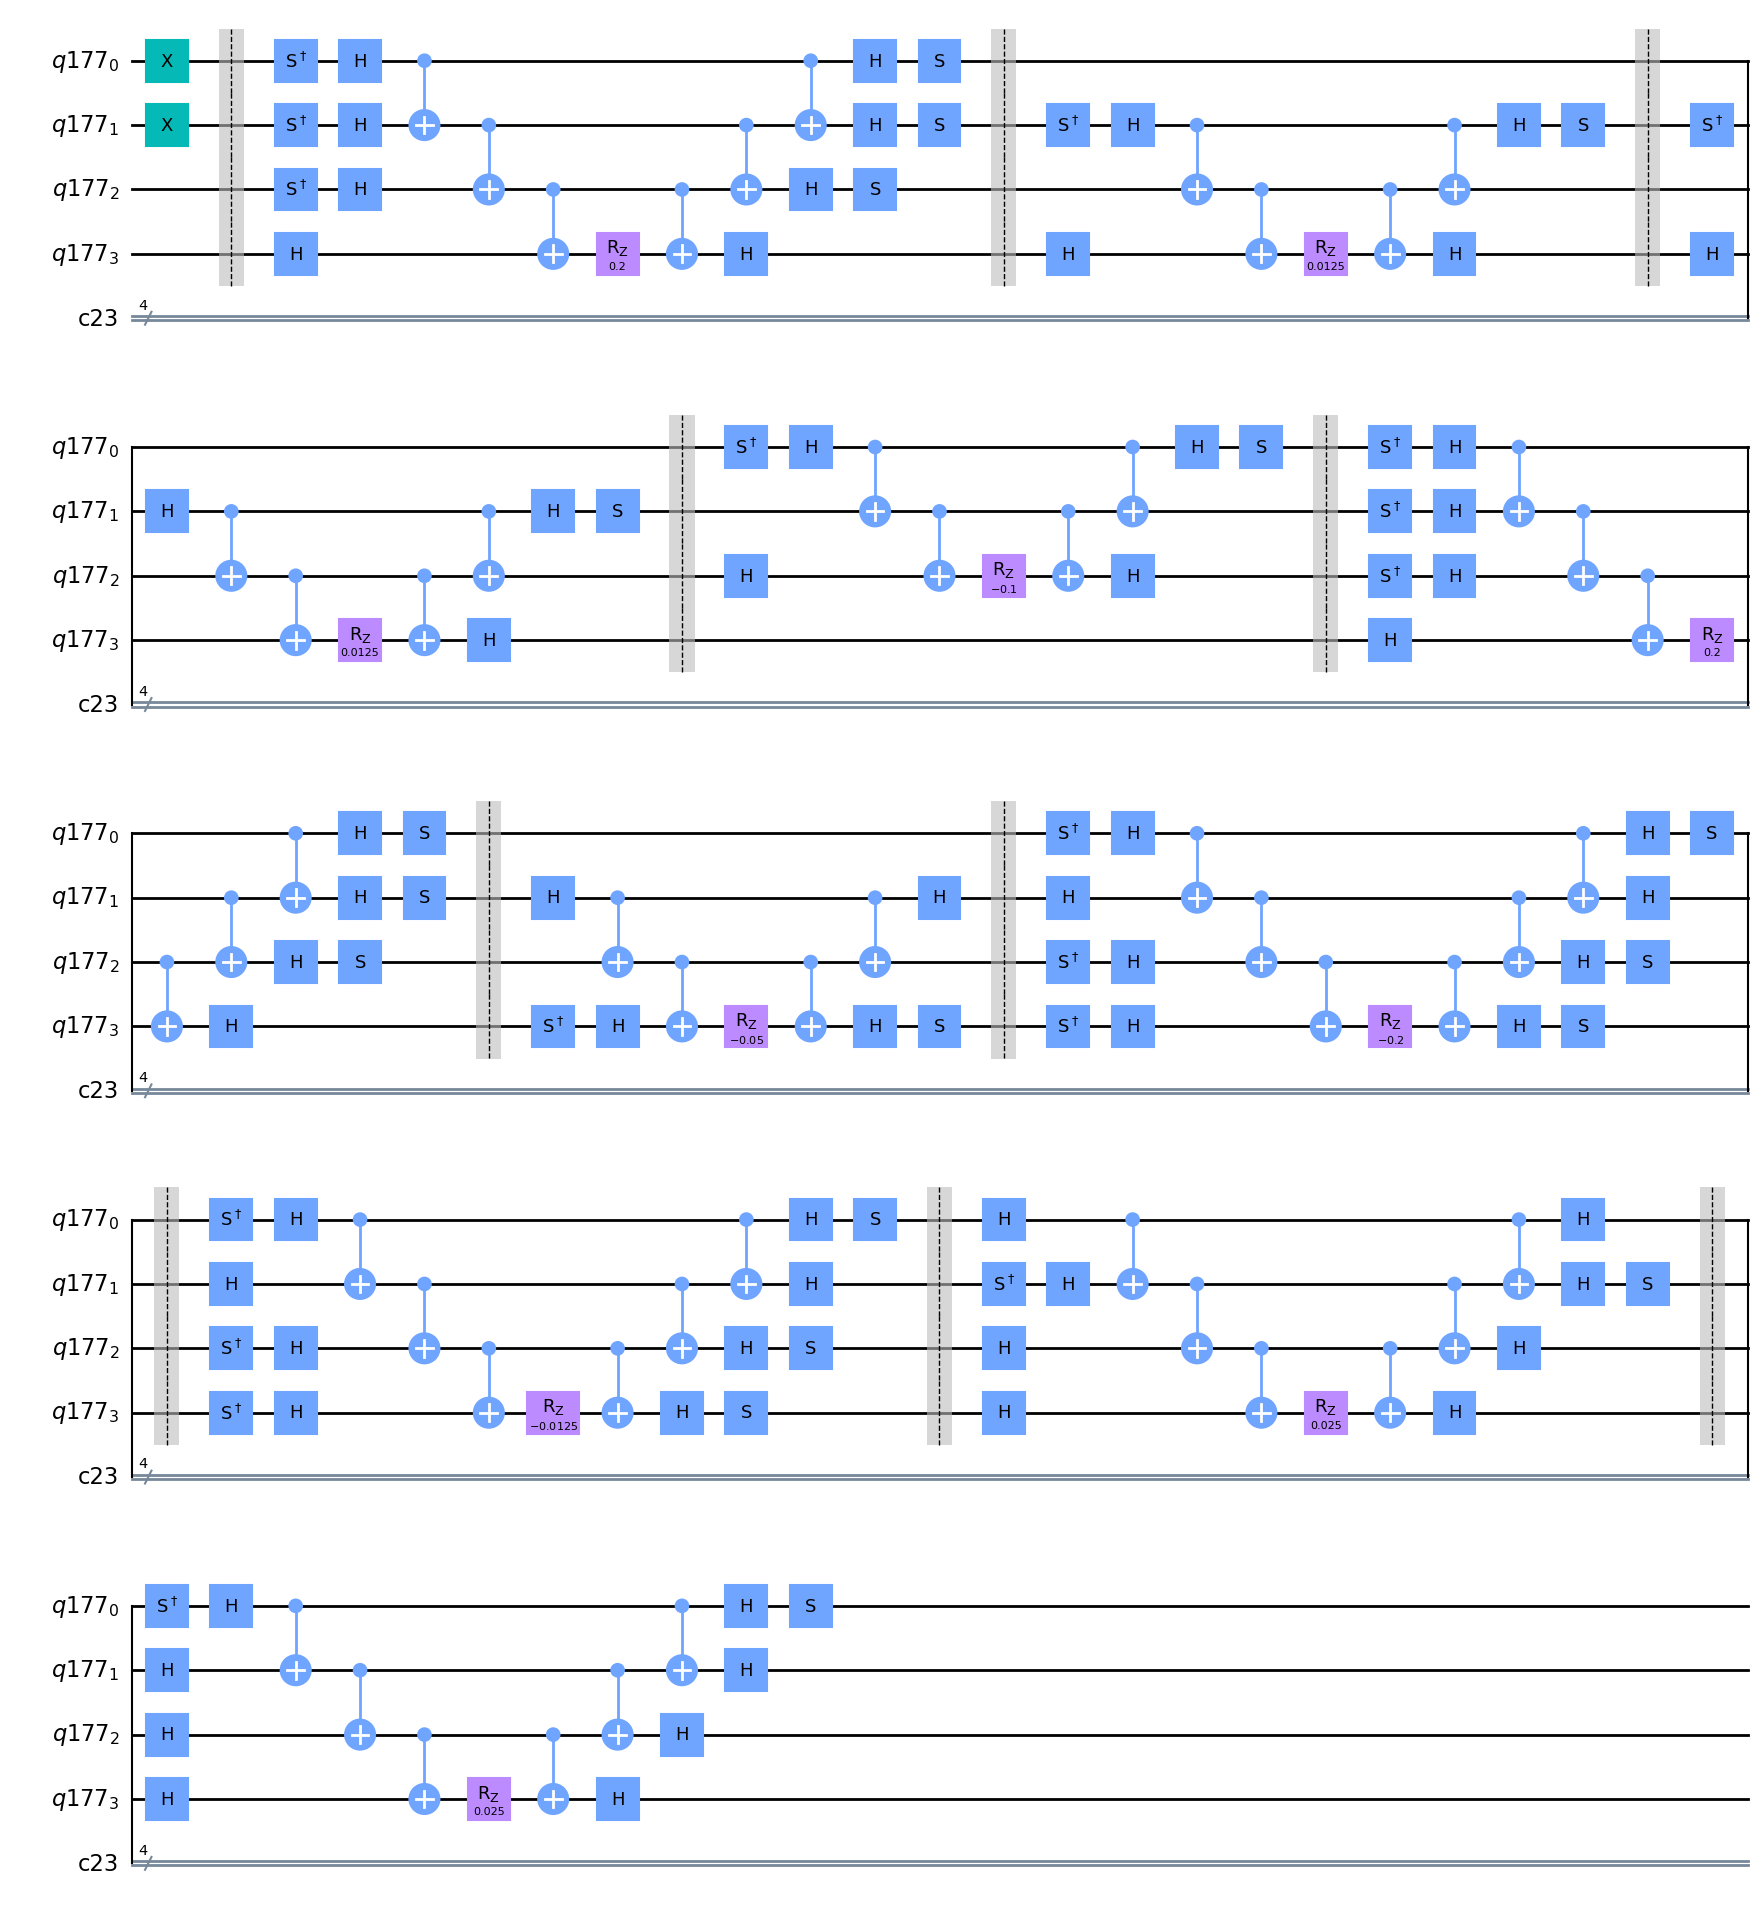

In [18]:
target = indices.cpu().numpy()[index]
print(cost.energy(torch.tensor([target]).to(get_device())))
print(target)
cost.sequence._get_circuit(target).qc.draw(output="mpl", plot_barriers=True)